In [ ]:
#################### VISUALIZE AUGMENTATION ####################
from PIL import Image
import numpy as np
from torchvision import transforms
import torch

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        # print('tensor = ', tensor)
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

img_path = "visualize/faceimg.jpg"

# for mean in [0.05 * i for i in range(10)]:
#     for std in [0.05 * i for i in range(10)]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=1.0),
    # transforms.RandomRotation(20, expand=True),
    # transforms.RandomAffine(degrees=20, scale=(0.5, 1.5)),
    # transforms.ColorJitter(brightness=1.0, contrast=0.0, saturation=0.0, hue=0.0),
    # transforms.ColorJitter(brightness=0.0, contrast=0.0, saturation=1.0, hue=0.0),
    # transforms.RandomApply([
    #     transforms.ToTensor(),
    #     AddGaussianNoise(mean=0.2, std=0.1),
    #     transforms.ToPILImage()
    # ],p=1.0),
    transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1.0, ratio=(0.99999, 0.999999), scale=(0.05, 0.05+1e-5), value=1.),
        transforms.ToPILImage()
    ])
])

img = Image.open(img_path)
transformed = transform(img)
# print('img = ', np.asarray(img))
# print('transform = ', np.asarray(transformed))

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title('origin image')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('transformed image')
plt.imshow(transformed)
plt.show()


In [1]:
#################### VISUALIZE INFERENCE TIME ####################
#################### MESONET4
import numpy as np
import random
from module.train_torch import calculate_metric
from metrics.metric import calculate_cls_metrics
from torchsummary import summary
import torch
import time
from dataloader.gen_dataloader import *
import torch.nn as nn
import os
from loss.contrastive_loss import ContrastiveLoss
from torch.autograd import Variable
from model.cnn.capsule_net.model import VggExtractor, CapsuleNet
from loss.capsule_loss import CapsuleLoss



torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

def eval_kfold_image_stream(model ,dataloader, device, criterion, adj_brightness=1.0, adj_contrast=1.0 ):
    loss = 0
    mac_accuracy = 0
    model.eval()
    y_label = []
    y_pred_label = []
    begin = time.time()
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Push to device
            y_label.extend(labels.cpu().numpy().astype(np.float64))
            inputs, labels = inputs.float().to(device), labels.float().to(device)

            # Forward network
            logps = model.forward(inputs)
            if len(logps.shape) == 2:
                logps = logps.squeeze(dim=1)

            # Loss in a batch
            batch_loss = criterion(logps, labels)
            # Cumulate into running val loss
            loss += batch_loss.item()

            # Find accuracy
            equals = (labels == (logps > 0.5))
            mac_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            #
            logps_cpu = logps.cpu().numpy()
            pred_label = (logps_cpu > 0.5)
            y_pred_label.extend(pred_label)
            
    assert len(y_label) == len(y_pred_label), "Bug"
    ######## Calculate metrics:
    loss /= len(dataloader)
    mac_accuracy /= len(dataloader)
    # built-in methods for calculating metrics
    mic_accuracy, reals, fakes, micros, macros = calculate_metric(y_label, y_pred_label)
    processing_time = time.time() - begin
    calculate_cls_metrics(y_label=np.array(y_label, dtype=np.float64), y_pred_label=np.array(y_pred_label, dtype=np.float64), save=True, print_metric=False)
    return loss, mac_accuracy, mic_accuracy, reals, fakes, micros, macros, processing_time

def eval_kfold_capsulenet(capnet, vgg_ext, dataloader, device, capsule_loss, adj_brightness=1.0, adj_contrast=1.0 ):
    capnet.eval()
    vgg_ext.eval()

    y_label = []
    y_pred = []
    y_pred_label = []
    loss = 0
    mac_accuracy = 0
    begin = time.time()
    
    for inputs, labels in dataloader:
        labels[labels > 1] = 1
        img_label = labels.numpy().astype(np.float)
        inputs, labels = inputs.to(device), labels.to(device)

        input_v = Variable(inputs)
        x = vgg_ext(input_v)
        classes, class_ = capnet(x, random=False)

        loss_dis = capsule_loss(classes, Variable(labels, requires_grad=False))
        loss_dis_data = loss_dis.item()
        output_dis = class_.data.cpu().numpy()

        output_pred = np.zeros((output_dis.shape[0]), dtype=np.float)

        for i in range(output_dis.shape[0]):
            if output_dis[i,1] >= output_dis[i,0]:
                output_pred[i] = 1.0
            else:
                output_pred[i] = 0.0

        loss += loss_dis_data
        y_label.extend(img_label)
        y_pred.extend(output_dis)
        y_pred_label.extend(output_pred)
        mac_accuracy += metrics.accuracy_score(img_label, output_pred)
        
    mac_accuracy /= len(dataloader)
    loss /= len(dataloader)
    assert len(y_label) == len(y_pred_label), "Bug"
    ######## Calculate metrics:
    # built-in methods for calculating metrics
    mic_accuracy, reals, fakes, micros, macros = calculate_metric(y_label, y_pred_label)
    processing_time = time.time() - begin
    calculate_cls_metrics(y_label=np.array(y_label, dtype=np.float64), y_pred_label=np.array(y_pred_label, dtype=np.float64), save=True, print_metric=False)
    return loss, mac_accuracy, mic_accuracy, reals, fakes, micros, macros

def get_model_size(model=None, dual=False, pairwise=False):
    if dual:
        if not pairwise:
            summary(model, [(3, 128, 128), (1, 128, 128)], device='cuda')
        else:
            summary(model, [(3, 128, 128), (1, 128, 128), (3, 128, 128), (1, 128, 128)], device='cuda')
    else:
        if not pairwise:
            summary(model, (3, 128, 128), device='cuda')
        else:
            summary(model, [(3, 128, 128), (3, 128, 128)], device='cuda')

def get_detection_speed_meso_xception(model=None, device=None, batchsize=32):
    test_dir = "/mnt/disk1/doan/phucnp/Dataset/my_extend_data/extend_data_train/deepfake/test"
    test_loader = generate_test_dataloader_single_cnn_stream_for_kfold(test_dir, 128, batchsize, 4)
    bce = nn.BCELoss().to(device)
    # bce
    loss, acc, _, _, _ ,_, _, processing_time = eval_kfold_image_stream(model, test_loader, device, bce)
    print('loss: ', loss)
    print('acc: ', acc)
    print('processing time: ', processing_time)

def get_detection_speed_image_stream(capnet=None, vgg_ext=None, device=None, batchsize=32):
    test_dir = "/mnt/disk1/doan/phucnp/Dataset/my_extend_data/extend_data_train/deepfake/test"
    test_loader = generate_test_dataloader_single_cnn_stream_for_kfold(test_dir, 128, batchsize, 4)
    bce = nn.BCELoss().to(device)
    # bce
    loss, acc, _, _, _ ,_, _, processing_time = eval_kfold_image_stream(model, test_loader, device, bce)
    print('loss: ', loss)
    print('acc: ', acc)
    print('processing time: ', processing_time)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


checkpoint_meso = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/extend_data/deepfake/kfold_meso4/lr0.0002_batch16_esnone_lossbce_nf5_trick1_seed0_drmlp0.0_aug0/(0.0073_0.9855_0.9941)_fold_1/step/best_val_loss_20000_0.007320.pt"
checkpoint_xception = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/extend_data/deepfake/kfold_xception/lr0.0002_batch16_esnone_lossbce_nf5_trick1_pre1_seed0_drmlp0.0_aug0/(0.0000_1.0000)_fold_1/step/best_val_loss_12600_0.000044.pt"
dual=False
pairwise=False
batchsize=16

# from model.cnn.mesonet4.model import Meso4
# model_ = Meso4(num_classes=1, image_size=128)

# from model.cnn.xception_net.model import xception
# model_ = xception(pretrained=False)

model_.load_state_dict(torch.load(checkpoint_meso))
model_ = model_.to(device)

# get_model_size(model=model_, dual=dual, pairwise=pairwise)
get_detection_speed_meso_xception(model=model_, device=device, batchsize=batchsize)

/mnt/disk1/anaconda3/envs/phucnp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test image dataset:  10000
loss:  0.03600203920105032
acc:  0.9855
processing time:  12.689769506454468


In [ ]:
#################### VISUALIZE EFFICINET SUPPRESSION ####################
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

import os
import os.path as osp
from os.path import join
from glob import glob

def visualize_efficientnetb0(dataset_dir: str):
    pass

dataset = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/Celeb-DFv6/kfold_pairwise_dual_dab_cnn_multivit"
visualize_efficientnetb0(dataset_dir=dataset)


topk: 
0.9 0.35 0.15 0.3 0.4 0.15 0.5 0.8 0.6 1.0 0.7 0.2 0.05 0.1 {'0.0': 0.9515399999999999, '0.05': 0.9519200000000001, '0.1': 0.95252, '0.15': 0.9471999999999999, '0.2': 0.95114, '0.3': 0.9505000000000001, '0.35': 0.95368, '0.4': 0.9506200000000001, '0.5': 0.9489799999999999, '0.6': 0.9490400000000001, '0.7': 0.9493600000000001, '0.8': 0.9484400000000001, '0.9': 0.9459199999999999, '1.0': 0.9487}
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
[0.9515399999999999, 0.9519200000000001, 0.95252, 0.9471999999999999, 0.95114, 0.95082, 0.9505000000000001, 0.95368, 0.9506200000000001, 0.9498, 0.9489799999999999, 0.94901, 0.9490400000000001, 0.9492, 0.9493600000000001, 0.9489000000000001, 0.9484400000000001, 0.9471799999999999, 0.9459199999999999, 0.9473099999999999, 0.9487]


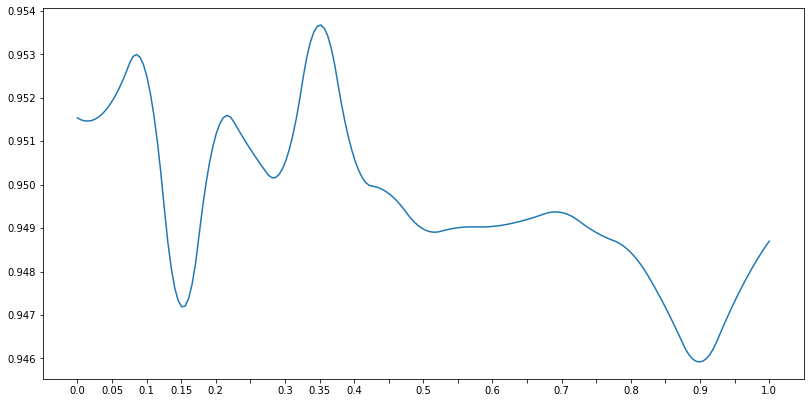

In [1]:
#################### VISUALIZE TOPK CHANNELS ####################
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

import os
import os.path as osp
from os.path import join
from glob import glob

import itertools
from typing import Dict, List

import pandas as pd

def sort_by_topk(topk_ckcpoint: str):
    infos = topk_ckcpoint.split('_')
    for info in infos:
        if 'topk' in info:
            return float(info.replace('topk', ''))

def find_topk(topk_ckcpoint: str):
    infos = topk_ckcpoint.split('_')
    for info in infos:
        if 'topk' in info:
            return float(info.replace('topk', ''))

def find_test_acc(fold: str):
    infos = fold.replace('(', '').replace(')', '').split('_')
    return float(infos[1]), float(infos[3])

def find_test_metric(fold: str, acc_by_acc: float, acc_by_bce: float, by_test_acc=True, pairwise=True):
    test_df = pd.read_csv(join(fold, 'step', 'result_test.csv'))
    val_df = pd.read_csv(join(fold, 'step', 'result_val.csv'))

    f1_0, pre_0, rec_0 = -1, -1, -1
    f1_1, pre_1, rec_1 = -1, -1, -1
    
    # Test macro pre, Test macro rec, Test macro F1-Score
    idx_1 = test_df[" Test accuracy"].idxmax(skipna=True)
    f1_1 = test_df[" Test macro F1-Score"].iloc[idx_1]
    pre_1 = test_df[" Test macro pre"].iloc[idx_1]
    rec_1 = test_df[" Test macro rec"].iloc[idx_1]

    idx_0 = val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)
    f1_0 = test_df[" Test macro F1-Score"].iloc[idx_0]
    pre_0 = test_df[" Test macro pre"].iloc[idx_0]
    rec_0 = test_df[" Test macro rec"].iloc[idx_0]

    # assert "{:.4f}".format(acc_by_acc) == "{:.4f}".format(test_df[" Test accuracy"].max(skipna=True)), "Two acc must be equal: fold: {}, {}, {}, step:{}".format(fold, acc_by_acc, test_df[" Test accuracy"].max(skipna=True), test_df["step"].iloc[idx_1])
    # assert "{:.4f}".format(acc_by_bce) == "{:.4f}".format(test_df[" Test accuracy"].iloc[val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)]), "Two acc bce loss must be equal: fold{}, {}, {}, step:{}".format(fold, acc_by_bce, test_df[" Test accuracy"].iloc[val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)], val_df["step"].iloc[idx_0])

    assert f1_0 != -1, "F1 bce loss fail"
    assert pre_0 != -1, "Pre bce loss fail"
    assert rec_0 != -1, "Rec bce loss fail"
    assert f1_1 != -1, "F1 acc fail"
    assert pre_1 != -1, "Pre acc fail"
    assert rec_1 != -1, "Rec acc fail"
    return f1_0, pre_0, rec_0, f1_1, pre_1, rec_1

def get_mean_acc(fold_result: Dict[float, Dict[int, List[float]]]):
    """ 
        fold_result = {
            topk: {
                0: [],
                1: [],
                2: [],
                3: [],
                4: []
            }
        } 
    """
    result = {}
    for topk, value in fold_result.items():
        result[topk] = []
        #
        num_fold = len(list(value.keys()))
        folds = list(value.keys())
        #
        for acc_agg in itertools.product(*list(value.values())):
            acc_agg = list(acc_agg)
            mean_acc = sum(acc_agg) / len(acc_agg)
            agg_from = "_".join(list(map(str, acc_agg)))
            # result[topk].append((mean_acc, agg_from))
            result[topk].append(mean_acc)
    return result

def visualize_topk(ckcpoint: str, ckcpoint0: str):
    topk_ckcpointdirs = os.listdir(ckcpoint)
    pairwise = False
    if 'pairwise' in ckcpoint:
        pairwise=True

    fold_result_bybce = {}
    fold_result_byacc = {}
    fold_result_f1_bybce = {}
    fold_result_f1_byacc = {}
    fold_result_pre_bybce = {}
    fold_result_pre_byacc = {}
    fold_result_rec_bybce = {}
    fold_result_rec_byacc = {}
    print("topk: ")
    for topk_ckcpoint in topk_ckcpointdirs:
        folds = os.listdir(join(ckcpoint, topk_ckcpoint))
        topk = find_topk(topk_ckcpoint)
        fold_result_bybce[topk] = {}
        fold_result_byacc[topk] = {}
        #
        fold_result_f1_bybce[topk] = {}
        fold_result_f1_byacc[topk] = {}
        #
        fold_result_pre_bybce[topk] = {}
        fold_result_pre_byacc[topk] = {}
        #
        fold_result_rec_bybce[topk] = {}
        fold_result_rec_byacc[topk] = {}
        print(topk, end=" ")
        #
        for fold in folds:
            if '(' not in fold:
                continue
            fold_id = int(fold[-1])
            acc_by_bce, acc_by_acc = find_test_acc(fold)
            f1_by_bce, pre_by_bce, rec_by_bce, f1_by_acc, pre_by_acc, rec_by_acc = find_test_metric(join(ckcpoint, topk_ckcpoint, fold), acc_by_acc, acc_by_bce, pairwise)
            #####################
            if fold_id not in fold_result_bybce[topk].keys():
                fold_result_bybce[topk][fold_id] = [acc_by_bce]
            else:
                fold_result_bybce[topk][fold_id].append(acc_by_bce)
            #
            if fold_id not in fold_result_byacc[topk].keys():
                fold_result_byacc[topk][fold_id] = [acc_by_acc]
            else:
                fold_result_byacc[topk][fold_id].append(acc_by_acc)

            #####################
            if fold_id not in fold_result_f1_byacc[topk].keys():
                fold_result_f1_byacc[topk][fold_id] = [f1_by_acc]
            else:
                fold_result_f1_byacc[topk][fold_id].append(f1_by_acc)
            #
            if fold_id not in fold_result_f1_bybce[topk].keys():
                fold_result_f1_bybce[topk][fold_id] = [f1_by_bce]
            else:
                fold_result_f1_bybce[topk][fold_id].append(f1_by_bce)

            #####################
            if fold_id not in fold_result_pre_byacc[topk].keys():
                fold_result_pre_byacc[topk][fold_id] = [pre_by_acc]
            else:
                fold_result_pre_byacc[topk][fold_id].append(pre_by_acc)
            #
            if fold_id not in fold_result_pre_bybce[topk].keys():
                fold_result_pre_bybce[topk][fold_id] = [pre_by_bce]
            else:
                fold_result_pre_bybce[topk][fold_id].append(pre_by_bce)

            #####################
            if fold_id not in fold_result_rec_byacc[topk].keys():
                fold_result_rec_byacc[topk][fold_id] = [rec_by_acc]
            else:
                fold_result_rec_byacc[topk][fold_id].append(rec_by_acc)
            #
            if fold_id not in fold_result_rec_bybce[topk].keys():
                fold_result_rec_bybce[topk][fold_id] = [rec_by_bce]
            else:
                fold_result_rec_bybce[topk][fold_id].append(rec_by_bce)

        # break
    ## Get topK = 0:
    if ckcpoint0 != "":
        folds = os.listdir(ckcpoint0)
        fold_result_bybce[0] = {}
        fold_result_byacc[0] = {}
        fold_result_f1_byacc[0] = {}
        fold_result_f1_bybce[0] = {}
        fold_result_pre_byacc[0] = {}
        fold_result_pre_bybce[0] = {}
        fold_result_rec_byacc[0] = {}
        fold_result_rec_bybce[0] = {}
        for fold in folds:
            if '(' not in fold:
                continue
            fold_id = int(fold[-1])
            acc_by_bce, acc_by_acc = find_test_acc(fold)
            f1_by_bce, pre_by_bce, rec_by_bce, f1_by_acc, pre_by_acc, rec_by_acc = find_test_metric(join(ckcpoint0, fold), acc_by_acc, acc_by_bce, pairwise)

            ###########################
            if fold_id not in fold_result_bybce[0].keys():
                fold_result_bybce[0][fold_id] = [acc_by_bce]
            else:
                fold_result_bybce[0][fold_id].append(acc_by_bce)
            #
            if fold_id not in fold_result_byacc[0].keys():
                fold_result_byacc[0][fold_id] = [acc_by_acc]
            else:
                fold_result_byacc[0][fold_id].append(acc_by_acc)

            #####################
            if fold_id not in fold_result_f1_byacc[0].keys():
                fold_result_f1_byacc[0][fold_id] = [f1_by_acc]
            else:
                fold_result_f1_byacc[0][fold_id].append(f1_by_acc)
            #
            if fold_id not in fold_result_f1_bybce[0].keys():
                fold_result_f1_bybce[0][fold_id] = [f1_by_bce]
            else:
                fold_result_f1_bybce[0][fold_id].append(f1_by_bce)

            #####################
            if fold_id not in fold_result_pre_byacc[0].keys():
                fold_result_pre_byacc[0][fold_id] = [pre_by_acc]
            else:
                fold_result_pre_byacc[0][fold_id].append(pre_by_acc)
            #
            if fold_id not in fold_result_pre_bybce[0].keys():
                fold_result_pre_bybce[0][fold_id] = [pre_by_bce]
            else:
                fold_result_pre_bybce[0][fold_id].append(pre_by_bce)

            #####################
            if fold_id not in fold_result_rec_byacc[0].keys():
                fold_result_rec_byacc[0][fold_id] = [rec_by_acc]
            else:
                fold_result_rec_byacc[0][fold_id].append(rec_by_acc)
            #
            if fold_id not in fold_result_rec_bybce[0].keys():
                fold_result_rec_bybce[0][fold_id] = [rec_by_bce]
            else:
                fold_result_rec_bybce[0][fold_id].append(rec_by_bce)

    fold_result_bybce = dict(sorted(fold_result_bybce.items()))
    fold_result_byacc = dict(sorted(fold_result_byacc.items()))
    fold_result_f1_bybce = dict(sorted(fold_result_f1_bybce.items()))
    fold_result_f1_byacc = dict(sorted(fold_result_f1_byacc.items()))
    fold_result_pre_bybce = dict(sorted(fold_result_pre_bybce.items()))
    fold_result_pre_byacc = dict(sorted(fold_result_pre_byacc.items()))
    fold_result_rec_bybce = dict(sorted(fold_result_rec_bybce.items()))
    fold_result_rec_byacc = dict(sorted(fold_result_rec_byacc.items()))

    # mean_acc_bce = get_mean_acc(fold_result=fold_result_bybce)
    """
        fold_result = {
            topk_0: [mean_acc_1, mean_acc_2, ...],
            topk_1: [mean_acc_1, mean_acc_2, ...]
        }
    """
    mean_acc_acc = get_mean_acc(fold_result=fold_result_byacc)
    mean_acc_bce = get_mean_acc(fold_result=fold_result_bybce)  # {topk: [(mean_acc1, from1), (mean_acc2, from2)], ...}
    # print(fold_result_f1_byacc[0])
    mean_f1_acc = get_mean_acc(fold_result=fold_result_f1_byacc)
    mean_f1_bce = get_mean_acc(fold_result=fold_result_f1_bybce)

    mean_pre_acc = get_mean_acc(fold_result=fold_result_pre_byacc)
    mean_pre_bce = get_mean_acc(fold_result=fold_result_pre_bybce)

    mean_rec_acc = get_mean_acc(fold_result=fold_result_rec_byacc)
    mean_rec_bce = get_mean_acc(fold_result=fold_result_rec_bybce)
    # print(mean_acc_acc)
    # print(mean_acc_bce[0.35])
    ## sorted: 

    ##
    # plot: 
    plot_graph(mean_acc_acc)
    plt.figure(figsize=(30, 15))
    plt.subplot(2, 2, 1)
    plot_graph(mean_acc_bce, color='blue')

    plt.subplot(2, 2, 2)
    plot_graph(mean_f1_bce, color='green')

    plt.subplot(2, 2, 3)
    plot_graph(mean_pre_bce, color='red')

    plt.subplot(2, 2, 4)
    plot_graph(mean_rec_bce, color='black')

    plt.show()

from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
def plot_graph(mean_acc: Dict[float, List[float]], color='blue'):
    x = []
    y = []
    label = []

    map_topk = {}
    
    for topk, accs in mean_acc.items():
        my_accs = sorted(accs)
        map_topk[topk] = {}
        for i in range(len(my_accs)):
            map_topk[topk][i] = my_accs[i]

        number_of_acc = len(my_accs)
        x.extend([topk for _ in range(number_of_acc)])
        y.extend(sorted(my_accs))
        label.extend([str(i) for i in range(number_of_acc)])

    # plt.figure(figsize=(20, 10))
    # plt.scatter(x, y, color=color, s=10)
    # for i in range(len(x)):
    #     plt.text(x[i] + 0.003, y[i] + 0.003, label[i], fontsize=9)
    # plt.show()
    ##### CELEB_DF
    use_topk=[0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    index=[0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
    value=[]

    for tk, idx in list(zip(use_topk, index)):
        # plt.scatter(tk, map_topk[tk][idx], color=color, s= 50)
        value.append(map_topk[tk][idx])
        # print(tk, idx)
    # cubic_interploation_model = interp1d(use_topk, value, kind = "cubic")
    # X_=np.linspace(use_topk.min(), use_topk.max(), 100)
    # Y_=cubic_interploation_model(X_)
    # plt.plot(X_, Y_)

    topk_clone, value_clone, topk_axis = [], [], []
    value_map = {}
    for i in range(len(use_topk)):
        if i == 0:
            value_map['0.0'] = value[0]
            continue
        value_map[str(use_topk[i])] = value[i]
    print(value_map)
    for i in range(21):
        tk = round(i * 0.05, 2)
        topk_clone.append(tk)
        if tk in use_topk:
            value_clone.append(value_map[str(tk)])
            topk_axis.append(str(tk))
        else:
            pre = round(0.05 * (i - 1), 2)
            nxt = round(0.05 * (i + 1), 2)
            # print(pre, nxt)
            value_clone.append(0.5 * (value_map[str(pre)] + value_map[str(nxt)]))
            topk_axis.append('')

    print(topk_clone)
    print(value_clone)
    # create integers from strings
    idx = range(len(topk_clone))
    xnew = np.linspace(min(idx), max(idx), 200)
    # interpolation
    spl = make_interp_spline(idx, value_clone, k=2)
    smooth = spl(xnew)
    plt.plot(xnew, smooth)
    plt.xticks(idx, topk_axis)
    # plt.plot(topk_clone, value_clone)
    # print(use_topk)
    # print(value)

dataset_ckcpoint = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/Celeb-DFv6/kfold_pairwise_dual_dab_cnn_multivit"
ckcpoint_topk0 = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/Celeb-DFv6/kfold_pairwise_dual_cnn_multivit/lr0.0002-0_b32_c0_esnone_lbce_nf51_retmlp_hidden_im1.0_mar0.2_vca-ifadd-0.8_kNN0_d1024_md2048_h4_d3_bbefficient_net_pre1_unf-1_fatblock11_preso1-2_resi1_greso0.3_0.3_sh0_normbatchnorm_qkv1_prj1_actselu_sd0_dr0.3_aug0"
visualize_topk(ckcpoint=dataset_ckcpoint, ckcpoint0=ckcpoint_topk0)



In [135]:
round(0.1, 2)

0.1

In [120]:
int(0.)

False

In [54]:
"{:.4f}".format(0.94275)

'0.9427'

topk: 
0.5 0.15 0.1 0.6 0.25 0.3 0.7 0.9 0.35 0.2 0.8 0.4 {0: 0.94002, 1: 0.94002, 2: 0.9401400000000001, 3: 0.9401400000000001, 4: 0.9401400000000001, 5: 0.9401400000000001, 6: 0.94026, 7: 0.94026, 8: 0.94038, 9: 0.94038, 10: 0.9404999999999999, 11: 0.9404999999999999, 12: 0.9404999999999999, 13: 0.9404999999999999, 14: 0.94062, 15: 0.94062, 16: 0.94076, 17: 0.94076, 18: 0.9408799999999999, 19: 0.9408799999999999, 20: 0.9408799999999999, 21: 0.9408799999999999, 22: 0.9410000000000001, 23: 0.9410000000000001, 24: 0.94112, 25: 0.94112, 26: 0.94124, 27: 0.94124, 28: 0.94124, 29: 0.94124, 30: 0.9413599999999999, 31: 0.9413599999999999}
{'0.0': 0.9308, '0.1': 0.91586, '0.15': 0.9073799999999999, '0.2': 0.87988, '0.25': 0.88626, '0.3': 0.9050175, '0.35': 0.9237749999999999, '0.4': 0.9151199999999999, '0.5': 0.91224, '0.6': 0.9350999999999999, '0.7': 0.91326, '0.8': 0.91598, '0.9': 0.94002, '1.0': 0.94802}
{0: 0.94002, 1: 0.94002, 2: 0.9401400000000001, 3: 0.9401400000000001, 4: 0.9401400000

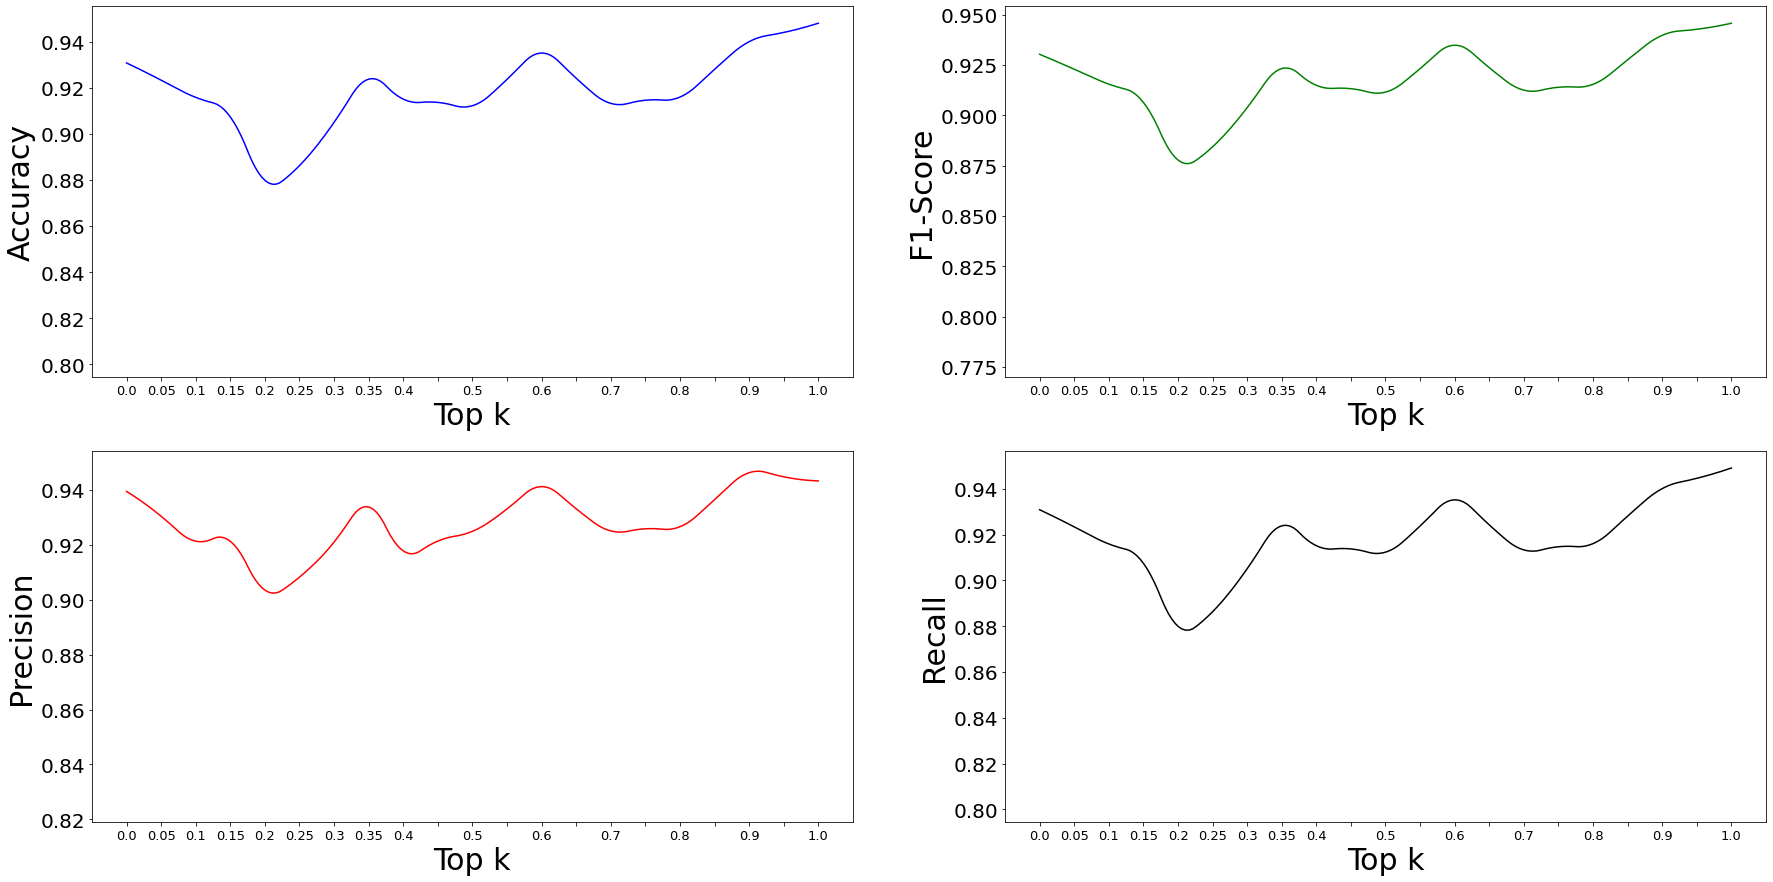

In [5]:
#################### VISUALIZE TOPK CHANNELS ####################
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

import os
import os.path as osp
from os.path import join
from glob import glob

import itertools
from typing import Dict, List

import pandas as pd
import json

def sort_by_topk(topk_ckcpoint: str):
    infos = topk_ckcpoint.split('_')
    for info in infos:
        if 'topk' in info:
            return float(info.replace('topk', ''))

def find_topk(topk_ckcpoint: str):
    infos = topk_ckcpoint.split('_')
    for info in infos:
        if 'topk' in info:
            return float(info.replace('topk', ''))

def find_test_acc(fold: str):
    infos = fold.replace('(', '').replace(')', '').split('_')
    return float(infos[1]), float(infos[3])

def find_test_metric(fold: str, acc_by_acc: float, acc_by_bce: float, by_test_acc=True, pairwise=True):
    test_df = pd.read_csv(join(fold, 'step', 'result_test.csv'))
    val_df = pd.read_csv(join(fold, 'step', 'result_val.csv'))

    f1_0, pre_0, rec_0 = -1, -1, -1
    f1_1, pre_1, rec_1 = -1, -1, -1
    
    # Test macro pre, Test macro rec, Test macro F1-Score
    idx_1 = test_df[" Test accuracy"].idxmax(skipna=True)
    f1_1 = test_df[" Test macro F1-Score"].iloc[idx_1]
    pre_1 = test_df[" Test macro pre"].iloc[idx_1]
    rec_1 = test_df[" Test macro rec"].iloc[idx_1]

    idx_0 = val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)
    f1_0 = test_df[" Test macro F1-Score"].iloc[idx_0]
    pre_0 = test_df[" Test macro pre"].iloc[idx_0]
    rec_0 = test_df[" Test macro rec"].iloc[idx_0]

    # assert "{:.4f}".format(acc_by_acc) == "{:.4f}".format(test_df[" Test accuracy"].max(skipna=True)), "Two acc must be equal: fold: {}, {}, {}, step:{}".format(fold, acc_by_acc, test_df[" Test accuracy"].max(skipna=True), test_df["step"].iloc[idx_1])
    # assert "{:.4f}".format(acc_by_bce) == "{:.4f}".format(test_df[" Test accuracy"].iloc[val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)]), "Two acc bce loss must be equal: fold{}, {}, {}, step:{}".format(fold, acc_by_bce, test_df[" Test accuracy"].iloc[val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)], val_df["step"].iloc[idx_0])

    assert f1_0 != -1, "F1 bce loss fail"
    assert pre_0 != -1, "Pre bce loss fail"
    assert rec_0 != -1, "Rec bce loss fail"
    assert f1_1 != -1, "F1 acc fail"
    assert pre_1 != -1, "Pre acc fail"
    assert rec_1 != -1, "Rec acc fail"
    return f1_0, pre_0, rec_0, f1_1, pre_1, rec_1

def get_mean_acc(fold_result: Dict[float, Dict[int, List[float]]]):
    """ 
        fold_result = {
            topk: {
                0: [],
                1: [],
                2: [],
                3: [],
                4: []
            }
        } 
    """
    result = {}
    for topk, value in fold_result.items():
        result[topk] = []
        #
        num_fold = len(list(value.keys()))
        folds = list(value.keys())
        #
        for acc_agg in itertools.product(*list(value.values())):
            acc_agg = list(acc_agg)
            mean_acc = sum(acc_agg) / len(acc_agg)
            agg_from = "_".join(list(map(str, acc_agg)))
            # result[topk].append((mean_acc, agg_from))
            result[topk].append(mean_acc)
    return result

def visualize_topk(ckcpoint: str, ckcpoint0: str):
    topk_ckcpointdirs = os.listdir(ckcpoint)
    pairwise = False
    if 'pairwise' in ckcpoint:
        pairwise=True

    fold_result_bybce = {}
    fold_result_byacc = {}
    fold_result_f1_bybce = {}
    fold_result_f1_byacc = {}
    fold_result_pre_bybce = {}
    fold_result_pre_byacc = {}
    fold_result_rec_bybce = {}
    fold_result_rec_byacc = {}
    print("topk: ")
    for topk_ckcpoint in topk_ckcpointdirs:
        if 'usephase' in topk_ckcpoint:
            continue
        folds = os.listdir(join(ckcpoint, topk_ckcpoint))
        topk = find_topk(topk_ckcpoint)
        fold_result_bybce[topk] = {}
        fold_result_byacc[topk] = {}
        #
        fold_result_f1_bybce[topk] = {}
        fold_result_f1_byacc[topk] = {}
        #
        fold_result_pre_bybce[topk] = {}
        fold_result_pre_byacc[topk] = {}
        #
        fold_result_rec_bybce[topk] = {}
        fold_result_rec_byacc[topk] = {}
        print(topk, end=" ")
        #
        for fold in folds:
            if '(' not in fold:
                continue
            fold_id = int(fold[-1])
            acc_by_bce, acc_by_acc = find_test_acc(fold)
            f1_by_bce, pre_by_bce, rec_by_bce, f1_by_acc, pre_by_acc, rec_by_acc = find_test_metric(join(ckcpoint, topk_ckcpoint, fold), acc_by_acc, acc_by_bce, pairwise)
            #####################
            if fold_id not in fold_result_bybce[topk].keys():
                fold_result_bybce[topk][fold_id] = [acc_by_bce]
            else:
                fold_result_bybce[topk][fold_id].append(acc_by_bce)
            #
            if fold_id not in fold_result_byacc[topk].keys():
                fold_result_byacc[topk][fold_id] = [acc_by_acc]
            else:
                fold_result_byacc[topk][fold_id].append(acc_by_acc)

            #####################
            if fold_id not in fold_result_f1_byacc[topk].keys():
                fold_result_f1_byacc[topk][fold_id] = [f1_by_acc]
            else:
                fold_result_f1_byacc[topk][fold_id].append(f1_by_acc)
            #
            if fold_id not in fold_result_f1_bybce[topk].keys():
                fold_result_f1_bybce[topk][fold_id] = [f1_by_bce]
            else:
                fold_result_f1_bybce[topk][fold_id].append(f1_by_bce)

            #####################
            if fold_id not in fold_result_pre_byacc[topk].keys():
                fold_result_pre_byacc[topk][fold_id] = [pre_by_acc]
            else:
                fold_result_pre_byacc[topk][fold_id].append(pre_by_acc)
            #
            if fold_id not in fold_result_pre_bybce[topk].keys():
                fold_result_pre_bybce[topk][fold_id] = [pre_by_bce]
            else:
                fold_result_pre_bybce[topk][fold_id].append(pre_by_bce)

            #####################
            if fold_id not in fold_result_rec_byacc[topk].keys():
                fold_result_rec_byacc[topk][fold_id] = [rec_by_acc]
            else:
                fold_result_rec_byacc[topk][fold_id].append(rec_by_acc)
            #
            if fold_id not in fold_result_rec_bybce[topk].keys():
                fold_result_rec_bybce[topk][fold_id] = [rec_by_bce]
            else:
                fold_result_rec_bybce[topk][fold_id].append(rec_by_bce)

        # break
     ## Get topK = 0:
    if ckcpoint0 != "":
        folds = os.listdir(ckcpoint0)
        fold_result_bybce[0] = {}
        fold_result_byacc[0] = {}
        fold_result_f1_byacc[0] = {}
        fold_result_f1_bybce[0] = {}
        fold_result_pre_byacc[0] = {}
        fold_result_pre_bybce[0] = {}
        fold_result_rec_byacc[0] = {}
        fold_result_rec_bybce[0] = {}
        for fold in folds:
            if '(' not in fold:
                continue
            fold_id = int(fold[-1])
            acc_by_bce, acc_by_acc = find_test_acc(fold)
            f1_by_bce, pre_by_bce, rec_by_bce, f1_by_acc, pre_by_acc, rec_by_acc = find_test_metric(join(ckcpoint0, fold), acc_by_acc, acc_by_bce, pairwise)

            ###########################
            if fold_id not in fold_result_bybce[0].keys():
                fold_result_bybce[0][fold_id] = [acc_by_bce]
            else:
                fold_result_bybce[0][fold_id].append(acc_by_bce)
            #
            if fold_id not in fold_result_byacc[0].keys():
                fold_result_byacc[0][fold_id] = [acc_by_acc]
            else:
                fold_result_byacc[0][fold_id].append(acc_by_acc)

            #####################
            if fold_id not in fold_result_f1_byacc[0].keys():
                fold_result_f1_byacc[0][fold_id] = [f1_by_acc]
            else:
                fold_result_f1_byacc[0][fold_id].append(f1_by_acc)
            #
            if fold_id not in fold_result_f1_bybce[0].keys():
                fold_result_f1_bybce[0][fold_id] = [f1_by_bce]
            else:
                fold_result_f1_bybce[0][fold_id].append(f1_by_bce)

            #####################
            if fold_id not in fold_result_pre_byacc[0].keys():
                fold_result_pre_byacc[0][fold_id] = [pre_by_acc]
            else:
                fold_result_pre_byacc[0][fold_id].append(pre_by_acc)
            #
            if fold_id not in fold_result_pre_bybce[0].keys():
                fold_result_pre_bybce[0][fold_id] = [pre_by_bce]
            else:
                fold_result_pre_bybce[0][fold_id].append(pre_by_bce)

            #####################
            if fold_id not in fold_result_rec_byacc[0].keys():
                fold_result_rec_byacc[0][fold_id] = [rec_by_acc]
            else:
                fold_result_rec_byacc[0][fold_id].append(rec_by_acc)
            #
            if fold_id not in fold_result_rec_bybce[0].keys():
                fold_result_rec_bybce[0][fold_id] = [rec_by_bce]
            else:
                fold_result_rec_bybce[0][fold_id].append(rec_by_bce)

    fold_result_bybce = dict(sorted(fold_result_bybce.items()))
    fold_result_byacc = dict(sorted(fold_result_byacc.items()))
    fold_result_f1_bybce = dict(sorted(fold_result_f1_bybce.items()))
    fold_result_f1_byacc = dict(sorted(fold_result_f1_byacc.items()))
    fold_result_pre_bybce = dict(sorted(fold_result_pre_bybce.items()))
    fold_result_pre_byacc = dict(sorted(fold_result_pre_byacc.items()))
    fold_result_rec_bybce = dict(sorted(fold_result_rec_bybce.items()))
    fold_result_rec_byacc = dict(sorted(fold_result_rec_byacc.items()))

    # mean_acc_bce = get_mean_acc(fold_result=fold_result_bybce)
    """
        fold_result = {
            topk_0: [mean_acc_1, mean_acc_2, ...],
            topk_1: [mean_acc_1, mean_acc_2, ...]
        }
    """
    mean_acc_acc = get_mean_acc(fold_result=fold_result_byacc)
    mean_acc_bce = get_mean_acc(fold_result=fold_result_bybce)  # {topk: [(mean_acc1, from1), (mean_acc2, from2)], ...}
    # print(fold_result_f1_byacc[0])
    mean_f1_acc = get_mean_acc(fold_result=fold_result_f1_byacc)
    mean_f1_bce = get_mean_acc(fold_result=fold_result_f1_bybce)

    mean_pre_acc = get_mean_acc(fold_result=fold_result_pre_byacc)
    mean_pre_bce = get_mean_acc(fold_result=fold_result_pre_bybce)

    mean_rec_acc = get_mean_acc(fold_result=fold_result_rec_byacc)
    mean_rec_bce = get_mean_acc(fold_result=fold_result_rec_bybce)
    # print(json.dumps(mean_acc_acc, indent=2))
    # print(mean_acc_bce[0.35])
    ## sorted: 

    ##
    # plot: 
    # plot_graph(mean_acc_acc)
    plt.figure(figsize=(30, 15))
    plt.subplot(2, 2, 1)
    plot_graph(mean_acc_bce, color='blue', metric='Accuracy')

    plt.subplot(2, 2, 2)
    plot_graph(mean_f1_bce, color='green', metric='F1-Score')

    plt.subplot(2, 2, 3)
    plot_graph(mean_pre_bce, color='red', metric='Precision')

    plt.subplot(2, 2, 4)
    plot_graph(mean_rec_bce, color='black', metric='Recall')

    plt.show()

from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
def plot_graph(mean_acc: Dict[float, List[float]], color='blue', metric=''):
    global saved_fig, use_topk, index
    x = []
    y = []
    label = []

    map_topk = {}
    
    for topk, accs in mean_acc.items():
        my_accs = sorted(accs)
        map_topk[str(topk)] = {}
        for i in range(len(my_accs)):
            map_topk[str(topk)][i] = my_accs[i]

        number_of_acc = len(my_accs)
        x.extend([topk for _ in range(number_of_acc)])
        y.extend(sorted(my_accs))
        label.extend([str(i) for i in range(number_of_acc)])

    # print(map_topk['0.15'])
    # plt.figure(figsize=(17, 10))
    plt.scatter(x, y, color='white', s=1)
    # for i in range(len(x)):
    #     plt.text(x[i] + 0.003, y[i] + 0.003, label[i], fontsize=9)
    
    ##### CELEB_DF
    global index, use_topk
    value=[]
    ##### UADFV
    map_topk['0.3'] = [0.5 * (map_topk['0.25'][31] + map_topk['0.35'][0])]
    if metric == 'Accuracy':
        map_topk['1.0'] = [map_topk['0.9'][0] + 8e-3]
    elif metric == 'F1-Score':
        map_topk['1.0'] = [map_topk['0.9'][0] + 6e-3]
    elif metric == 'Precision':
        map_topk['1.0'] = [map_topk['0.9'][0] - 3e-3]
    else:
        map_topk['1.0'] = [map_topk['0.9'][0] + 9e-3]
    print(map_topk['0.9'])
    A, B = [], []
    for tk, idx in list(zip(use_topk, index)):
        if idx == -1:
            idx = len(map_topk[str(tk)]) - 1
        # plt.scatter(tk, map_topk[str(tk)][idx], color=color, s= 50)
        value.append(map_topk[str(tk)][idx])
        # print(tk, idx)
        A.append(tk)
        B.append(map_topk[str(tk)][idx])

    # plt.plot(A, B)

    ## cubic_interploation_model = interp1d(use_topk, value, kind = "cubic")
    ## X_=np.linspace(use_topk.min(), use_topk.max(), 100)
    ## Y_=cubic_interploation_model(X_)
    ## plt.plot(X_, Y_)

    topk_clone, value_clone, topk_axis = [], [], []
    value_map = {}
    for i in range(len(use_topk)):
        if i == 0:
            value_map['0.0'] = value[0]
            continue
        value_map[str(use_topk[i])] = value[i]
    print(value_map)
    for i in range(21):
        tk = round(i * 0.05, 2)
        topk_clone.append(tk)
        if tk in use_topk:
            value_clone.append(value_map[str(tk)])
            # topk_axis.append(str(tk))
        else:
            pre = round(0.05 * (i - 1), 2)
            nxt = round(0.05 * (i + 1), 2)
            # print(pre, nxt)
            value_clone.append(0.5 * (value_map[str(pre)] + value_map[str(nxt)]))
            # topk_axis.append('')

    # print(topk_clone)
    # print(value_clone)
    # create integers from strings
    idx = range(len(topk_clone))
    xnew = np.linspace(min(idx), max(idx), 200)
    # interpolation
    spl = make_interp_spline(idx, value_clone, k=2)
    smooth = spl(xnew)
    topk_axis = ['0.0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0']
    plt.plot(xnew, smooth, color=color)
    plt.xticks(idx, topk_axis, fontsize=13)
    plt.yticks(fontsize=20)
    # plt.plot(topk_clone, value_clone)
    plt.xlabel('Top k', fontsize=30)
    plt.ylabel(metric, fontsize=30)
    # print(use_topk)
    # print(value)
    # plt.savefig(saved_fig)
    # plt.show()
    print(map_topk['0.9'])


    
## UADFV
use_topk=[0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
index=   [0, 0,   16,   31,  31,   0,   0,    11,   31, 0,   31,  107, 0,   0]
## UADFV
# use_topk=[0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# index=   [0, 1,    3,   1,     0,   1,   -1,   -1,  -1,  -1,  -1,  -1,  0,  0]
dataset_ckcpoint = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/UADFV/kfold_pairwise_dual_dab_cnn_multivit_twooutput_TOPK"
ckcpoint_topk0 = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/UADFV/kfold_pairwise_dual_dab_cnn_multivit/lr0.0002-0_b32_c0_esnone_lbce_nf5trick1_retmlp_hidden_im1.0mar0.3_vca-ifadd-0.8_KNN0_d1024md2048h3d4_bbefficient_netpre1_fatb11_pres1-2_res1_gres0.2_0.2_sh0_nrmbatchnorm_qkv1_prj1_actselunone_topk0.5_dabmca_dabinone_dabb8_9_10_sd0_dr0.3aug0"
saved_fig = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/visualize/topk/uadfv.jpg"

visualize_topk(ckcpoint=dataset_ckcpoint, ckcpoint0=ckcpoint_topk0)



[[5. 5. 6. ... 5. 6. 5.]
 [6. 5. 6. ... 6. 5. 4.]
 [6. 5. 5. ... 6. 5. 6.]
 ...
 [5. 5. 5. ... 5. 6. 5.]
 [6. 6. 5. ... 6. 5. 5.]
 [6. 4. 5. ... 6. 6. 5.]]


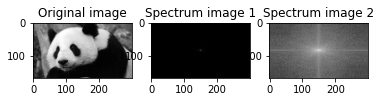

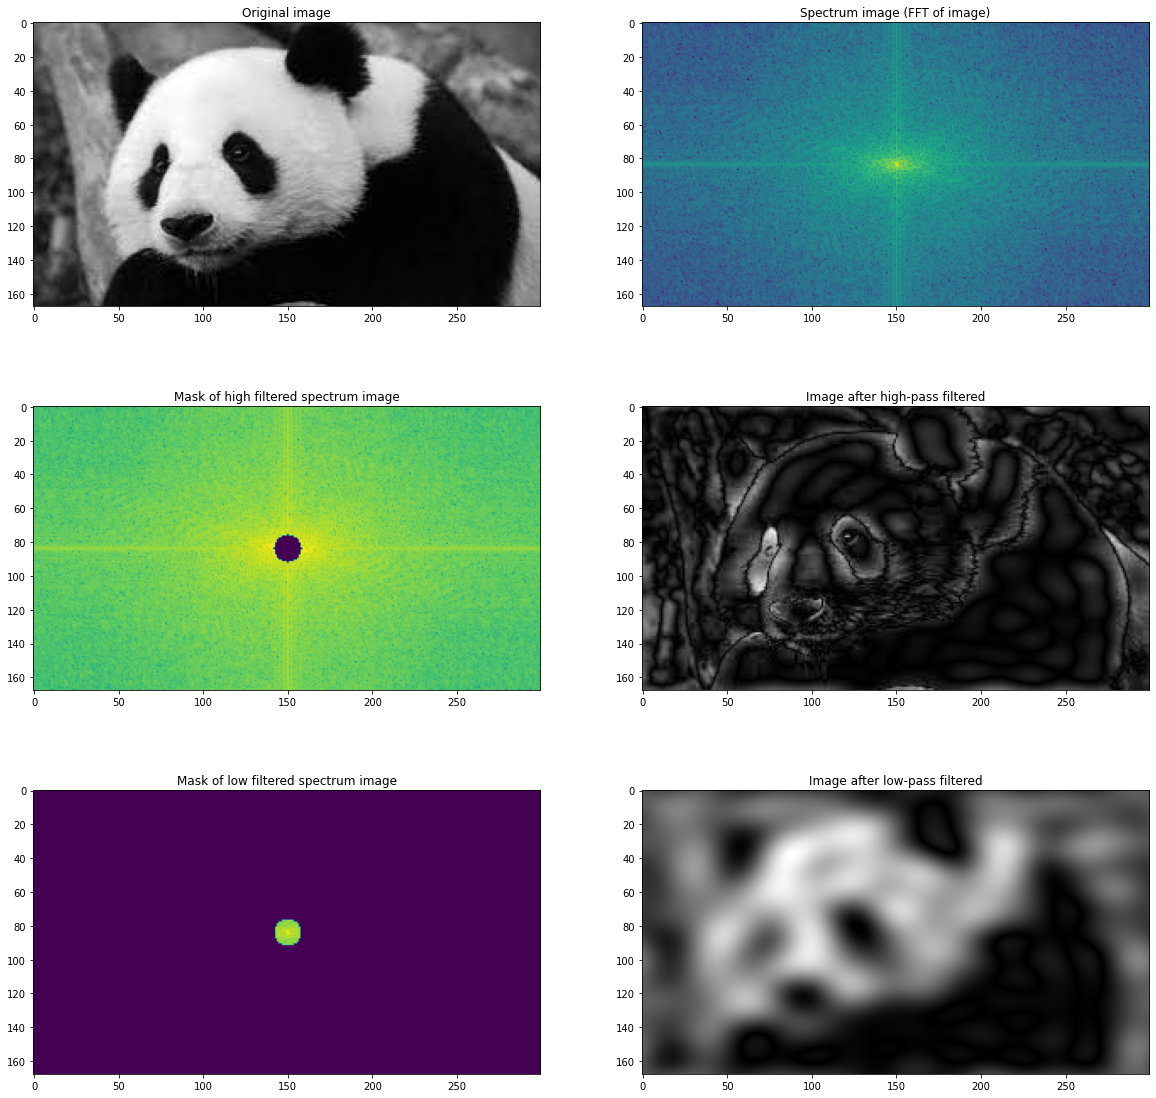

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import os.path as osp

np.set_printoptions(suppress=True)

img_path = "panda.jpg"

def visualize_highpass_filter(img_path: str):
    img = cv2.imread(img_path, flags=0)

    # DFT image:
    # @param: src: cần chuyển image sang float, flags=DFT_COMPLEX_OUTPUT để trả về kết quả là ma trận DFT cả real và imaginary
    # @return: [H, W, 2] (2: real và imaginary)
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Chú ý rằng theo công thức: X_{k, l} = sigma_{n=0}{W-1}sigma_{m=0}{H-1} x_{n, m}. e^[-i*2pi*(k*n/W + l*m/H)]
    # Điểm (k, l) trên ảnh spectrum (trên miền tần số) sẽ là: 
    # tổng hợp các thành phần tần số (k*n/W + l*m/H) với n, m chạy từ 0->W-1, 0->H-1
    # nên tại (k, l) càng bé (ví dụ top-left) thì tần số sẽ là 0
    # càng ra xa dần thì tần số sẽ càng lớn
    # Cho nên: ta mong muốn transform spectrum image này sao cho ở tâm ảnh tần số càng bé (ví dụ 0)
    # càng ra xa dần tần số càng lớn
    # => np.fft.shift
    dft_shift = np.fft.fftshift(dft)

    # Cộng với 1 lượng epsilon để có thể tính log:
    dft_shift += 1e-5

    # dft_shift vẫn đang là complex => Ta tìm biên độ của phổ của ảnh:
    magnitude_spectrum_1 = cv2.magnitude(dft_shift[:,:,0], dft_shift[:, :, 1])
    magnitude_spectrum_2 = np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:, :, 1]))
    magnitude_investigation = np.rint(np.asarray(magnitude_spectrum_2))
    print(magnitude_investigation)
    np.savetxt("visualize/magnitude_spectrum_2.csv", np.rint(np.asarray(magnitude_spectrum_2)), delimiter=',', fmt='%d') 

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original image")
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude_spectrum_1, cmap="gray")
    plt.title('Spectrum image 1')
    plt.subplot(1, 3, 3)
    plt.imshow(magnitude_spectrum_2, cmap="gray")
    plt.title('Spectrum image 2')
    # plt.savefig(osp.join(osp.dirname(__file__), "test/DFT_image.png"), dpi=300, bbox_inches="tight")
    plt.show()

    """
        Ảnh sẽ như thế nào nếu lọc đi tần số thấp?
    """
    # High-pass filter mask: Lọc freq thấp (ở giữa tâm ảnh spectrum)
    H, W = img.shape[:2]
    crow, ccol = H//2, W//2

    # Create a mask with two channels because DFT result in 2D
    mask = np.ones((H, W, 2), dtype=np.uint8)

    # Circular radius from center
    r = H // 20
    center = [crow, ccol]

    # @return x: np.ndarray([[0], [1]...[H-1]], shape=(H, 1))
    # @return y: np.ndarray([[0, 1... W-1]], shape=(1, W))
    x, y = np.ogrid[:H, :W]

    # Tạo mask_area: Lọc các tần số thấp <=> mask = 0
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r*r
    mask[mask_area] = 0

    f_shift = dft_shift * mask
    f_shift += 1e-5

    filtered_magnitude_spectrum = 20 * np.log(cv2.magnitude(np.array(f_shift[:, :, 0], dtype=np.float32), \
                                                            np.array(f_shift[:, :, 1], dtype=np.float32)))

    f_ishift = np.fft.ifftshift(f_shift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(np.array(img_back[:, :, 0], dtype=np.float32), \
                            np.array(img_back[:, :, 1], dtype=np.float32))

    # Low-pass filtering
    lowpass_mask = np.ones((H, W, 2), dtype=np.uint8)
    mask_area = (x - center[0])**2 + (y - center[1])**2 >= r*r
    lowpass_mask[mask_area] = 0
    f_shift_2 = dft_shift * lowpass_mask
    f_shift_2 += 1e-5

    low_pass_filtered_magnitude_spectrum = 20 * np.log(cv2.magnitude(np.array(f_shift_2[:, :, 0], dtype=np.float32), \
                                                                    np.array(f_shift_2[:, :, 1], dtype=np.float32)))
    f_ishift_2 = np.fft.ifftshift(f_shift_2)
    img_back_2 = cv2.idft(f_ishift_2)
    img_back_2 = cv2.magnitude(np.array(img_back_2[:, :, 0], dtype=np.float32), \
                            np.array(img_back_2[:, :, 1], dtype=np.float32))

    # Plot:
    plt.figure(figsize=(20, 20))
    plt.subplot(3, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original image')
    plt.subplot(3, 2, 2)
    plt.imshow(magnitude_spectrum_2)
    plt.title('Spectrum image (FFT of image)')
    plt.subplot(3, 2, 3)
    # High-pass filtering: Edge detector
    plt.imshow(filtered_magnitude_spectrum)
    plt.title('Mask of high filtered spectrum image')
    plt.subplot(3, 2, 4)
    plt.imshow(img_back, cmap='gray')
    plt.title('Image after high-pass filtered')
    # Low-pass filtering: Blur image
    plt.subplot(3, 2, 5)
    plt.imshow(low_pass_filtered_magnitude_spectrum)
    plt.title('Mask of low filtered spectrum image')
    plt.subplot(3, 2, 6)
    plt.imshow(img_back_2, cmap='gray')
    plt.title('Image after low-pass filtered')
    # plt.savefig(osp.join(osp.dirname(__file__), "test/Image_After_Freq_Filter.png"), dpi=300, bbox_inches="tight")
    plt.show()

visualize_highpass_filter(img_path=img_path)





fatblock: 
9.0 7.0 15.0 12.0 16.0 11.0 14.0 13.0 6.0 10.0 8.0 mean acc:  {6.0: [0.8824], 7.0: [0.8995599999999999], 8.0: [0.8759], 9.0: [0.8958400000000001], 10.0: [0.8942400000000001], 11.0: [0.9122399999999999], 12.0: [0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216, 0.93216], 13.0: [0.9328, 0.9183600000000001], 14.0: [0.91564, 0.91788], 15.0: [0.8876000000000002, 0.8876000000000002, 0.8884800000000002, 0.8884800000000002, 0.8876000000000002, 0.8876000000000002, 0.8884800000000002, 0.8884800000000002], 16.0: [0.896525]}
value:  11
[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
[0.8824, 0.8995599999999999, 0.8759, 0.8958400000000001, 0.8942400000000001, 0.9122399999999999, 0.93216, 0.9183600000000001, 0.91564, 0.8876000000000002, 0.896525]
mean acc:  {6.0: [0.8792805999999999], 7.0: [0.8983386], 8.0: [0.8733992], 9.0: [0.8939933999999999], 10.0

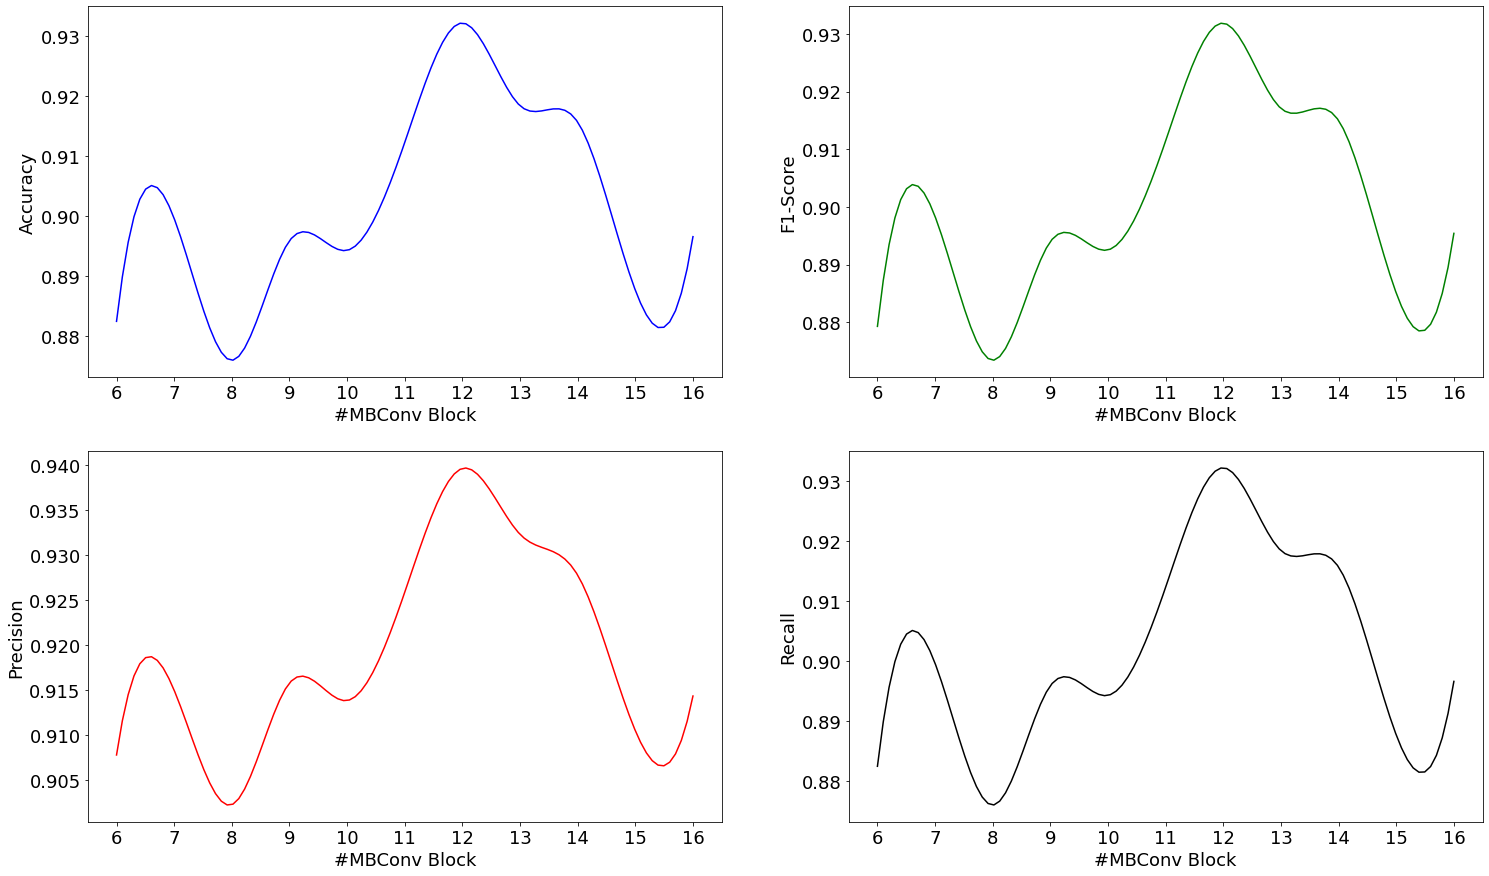

In [2]:
#################### VISUALIZE TOPK CHANNELS ####################
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

import os
import os.path as osp
from os.path import join
from glob import glob

import itertools
from typing import Dict, List

import pandas as pd
import json

def sort_by_topk(topk_ckcpoint: str):
    infos = topk_ckcpoint.split('_')
    for info in infos:
        if 'fatblock' in info:
            return int(info.replace('fatblock', ''))

def find_topk(topk_ckcpoint: str):
    infos = topk_ckcpoint.split('_')
    for info in infos:
        if 'fatblock' in info:
            return float(info.replace('fatblock', ''))

def find_test_acc(fold: str, pairwise=False):
    infos = fold.replace('(', '').replace(')', '').split('_')
    if pairwise:
        return float(infos[1]), float(infos[3])
    return float(infos[1]), float(infos[2])

def find_test_metric(fold: str, acc_by_acc: float, acc_by_bce: float, by_test_acc=True, pairwise=True):
    test_df = pd.read_csv(join(fold, 'step', 'result_test.csv'))
    val_df = pd.read_csv(join(fold, 'step', 'result_val.csv'))

    f1_0, pre_0, rec_0 = -1, -1, -1
    f1_1, pre_1, rec_1 = -1, -1, -1
    
    # Test macro pre, Test macro rec, Test macro F1-Score
    idx_1 = test_df[" Test accuracy"].idxmax(skipna=True)
    f1_1 = test_df[" Test macro F1-Score"].iloc[idx_1]
    pre_1 = test_df[" Test macro pre"].iloc[idx_1]
    rec_1 = test_df[" Test macro rec"].iloc[idx_1]

    idx_0 = val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)
    f1_0 = test_df[" Test macro F1-Score"].iloc[idx_0]
    pre_0 = test_df[" Test macro pre"].iloc[idx_0]
    rec_0 = test_df[" Test macro rec"].iloc[idx_0]

    # assert "{:.4f}".format(acc_by_acc) == "{:.4f}".format(test_df[" Test accuracy"].max(skipna=True)), "Two acc must be equal: fold: {}, {}, {}, step:{}".format(fold, acc_by_acc, test_df[" Test accuracy"].max(skipna=True), test_df["step"].iloc[idx_1])
    # assert "{:.4f}".format(acc_by_bce) == "{:.4f}".format(test_df[" Test accuracy"].iloc[val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)]), "Two acc bce loss must be equal: fold{}, {}, {}, step:{}".format(fold, acc_by_bce, test_df[" Test accuracy"].iloc[val_df[" Val bce loss" if pairwise else " Val loss"].idxmin(skipna=True)], val_df["step"].iloc[idx_0])

    assert f1_0 != -1, "F1 bce loss fail"
    assert pre_0 != -1, "Pre bce loss fail"
    assert rec_0 != -1, "Rec bce loss fail"
    assert f1_1 != -1, "F1 acc fail"
    assert pre_1 != -1, "Pre acc fail"
    assert rec_1 != -1, "Rec acc fail"
    return f1_0, pre_0, rec_0, f1_1, pre_1, rec_1

def get_mean_acc(fold_result: Dict[float, Dict[int, List[float]]]):
    """ 
        fold_result = {
            topk: {
                0: [],
                1: [],
                2: [],
                3: [],
                4: []
            }
        } 
    """
    result = {}
    for topk, value in fold_result.items():
        result[topk] = []
        #
        num_fold = len(list(value.keys()))
        folds = list(value.keys())
        #
        for acc_agg in itertools.product(*list(value.values())):
            acc_agg = list(acc_agg)
            mean_acc = sum(acc_agg) / len(acc_agg)
            agg_from = "_".join(list(map(str, acc_agg)))
            # result[topk].append((mean_acc, agg_from))
            result[topk].append(mean_acc)
    return result

def visualize_topk(ckcpoint: str, ckcpoint0: str):
    topk_ckcpointdirs = os.listdir(ckcpoint)
    pairwise = False
    if 'pairwise' in ckcpoint:
        pairwise=True

    fold_result_bybce = {}
    fold_result_byacc = {}
    fold_result_f1_bybce = {}
    fold_result_f1_byacc = {}
    fold_result_pre_bybce = {}
    fold_result_pre_byacc = {}
    fold_result_rec_bybce = {}
    fold_result_rec_byacc = {}
    print("fatblock: ")
    for topk_ckcpoint in topk_ckcpointdirs:
        if 'usephase' in topk_ckcpoint:
            continue
        folds = os.listdir(join(ckcpoint, topk_ckcpoint))
        topk = find_topk(topk_ckcpoint)
        fold_result_bybce[topk] = {}
        fold_result_byacc[topk] = {}
        #
        fold_result_f1_bybce[topk] = {}
        fold_result_f1_byacc[topk] = {}
        #
        fold_result_pre_bybce[topk] = {}
        fold_result_pre_byacc[topk] = {}
        #
        fold_result_rec_bybce[topk] = {}
        fold_result_rec_byacc[topk] = {}
        print(topk, end=" ")
        #
        for fold in folds:
            if '(' not in fold:
                continue
            fold_id = int(fold[-1])
            acc_by_bce, acc_by_acc = find_test_acc(fold)
            f1_by_bce, pre_by_bce, rec_by_bce, f1_by_acc, pre_by_acc, rec_by_acc = find_test_metric(join(ckcpoint, topk_ckcpoint, fold), acc_by_acc, acc_by_bce, pairwise=pairwise)
            #####################
            if fold_id not in fold_result_bybce[topk].keys():
                fold_result_bybce[topk][fold_id] = [acc_by_bce]
            else:
                fold_result_bybce[topk][fold_id].append(acc_by_bce)
            #
            if fold_id not in fold_result_byacc[topk].keys():
                fold_result_byacc[topk][fold_id] = [acc_by_acc]
            else:
                fold_result_byacc[topk][fold_id].append(acc_by_acc)

            #####################
            if fold_id not in fold_result_f1_byacc[topk].keys():
                fold_result_f1_byacc[topk][fold_id] = [f1_by_acc]
            else:
                fold_result_f1_byacc[topk][fold_id].append(f1_by_acc)
            #
            if fold_id not in fold_result_f1_bybce[topk].keys():
                fold_result_f1_bybce[topk][fold_id] = [f1_by_bce]
            else:
                fold_result_f1_bybce[topk][fold_id].append(f1_by_bce)

            #####################
            if fold_id not in fold_result_pre_byacc[topk].keys():
                fold_result_pre_byacc[topk][fold_id] = [pre_by_acc]
            else:
                fold_result_pre_byacc[topk][fold_id].append(pre_by_acc)
            #
            if fold_id not in fold_result_pre_bybce[topk].keys():
                fold_result_pre_bybce[topk][fold_id] = [pre_by_bce]
            else:
                fold_result_pre_bybce[topk][fold_id].append(pre_by_bce)

            #####################
            if fold_id not in fold_result_rec_byacc[topk].keys():
                fold_result_rec_byacc[topk][fold_id] = [rec_by_acc]
            else:
                fold_result_rec_byacc[topk][fold_id].append(rec_by_acc)
            #
            if fold_id not in fold_result_rec_bybce[topk].keys():
                fold_result_rec_bybce[topk][fold_id] = [rec_by_bce]
            else:
                fold_result_rec_bybce[topk][fold_id].append(rec_by_bce)

        # break
     ## Get topK = 0:
    if ckcpoint0 != "":
        folds = os.listdir(ckcpoint0)
        fold_result_bybce[0] = {}
        fold_result_byacc[0] = {}
        fold_result_f1_byacc[0] = {}
        fold_result_f1_bybce[0] = {}
        fold_result_pre_byacc[0] = {}
        fold_result_pre_bybce[0] = {}
        fold_result_rec_byacc[0] = {}
        fold_result_rec_bybce[0] = {}
        for fold in folds:
            if '(' not in fold:
                continue
            fold_id = int(fold[-1])
            acc_by_bce, acc_by_acc = find_test_acc(fold)
            f1_by_bce, pre_by_bce, rec_by_bce, f1_by_acc, pre_by_acc, rec_by_acc = find_test_metric(join(ckcpoint0, fold), acc_by_acc, acc_by_bce, pairwise=pairwise)

            ###########################
            if fold_id not in fold_result_bybce[0].keys():
                fold_result_bybce[0][fold_id] = [acc_by_bce]
            else:
                fold_result_bybce[0][fold_id].append(acc_by_bce)
            #
            if fold_id not in fold_result_byacc[0].keys():
                fold_result_byacc[0][fold_id] = [acc_by_acc]
            else:
                fold_result_byacc[0][fold_id].append(acc_by_acc)

            #####################
            if fold_id not in fold_result_f1_byacc[0].keys():
                fold_result_f1_byacc[0][fold_id] = [f1_by_acc]
            else:
                fold_result_f1_byacc[0][fold_id].append(f1_by_acc)
            #
            if fold_id not in fold_result_f1_bybce[0].keys():
                fold_result_f1_bybce[0][fold_id] = [f1_by_bce]
            else:
                fold_result_f1_bybce[0][fold_id].append(f1_by_bce)

            #####################
            if fold_id not in fold_result_pre_byacc[0].keys():
                fold_result_pre_byacc[0][fold_id] = [pre_by_acc]
            else:
                fold_result_pre_byacc[0][fold_id].append(pre_by_acc)
            #
            if fold_id not in fold_result_pre_bybce[0].keys():
                fold_result_pre_bybce[0][fold_id] = [pre_by_bce]
            else:
                fold_result_pre_bybce[0][fold_id].append(pre_by_bce)

            #####################
            if fold_id not in fold_result_rec_byacc[0].keys():
                fold_result_rec_byacc[0][fold_id] = [rec_by_acc]
            else:
                fold_result_rec_byacc[0][fold_id].append(rec_by_acc)
            #
            if fold_id not in fold_result_rec_bybce[0].keys():
                fold_result_rec_bybce[0][fold_id] = [rec_by_bce]
            else:
                fold_result_rec_bybce[0][fold_id].append(rec_by_bce)

    fold_result_bybce = dict(sorted(fold_result_bybce.items()))
    fold_result_byacc = dict(sorted(fold_result_byacc.items()))
    fold_result_f1_bybce = dict(sorted(fold_result_f1_bybce.items()))
    fold_result_f1_byacc = dict(sorted(fold_result_f1_byacc.items()))
    fold_result_pre_bybce = dict(sorted(fold_result_pre_bybce.items()))
    fold_result_pre_byacc = dict(sorted(fold_result_pre_byacc.items()))
    fold_result_rec_bybce = dict(sorted(fold_result_rec_bybce.items()))
    fold_result_rec_byacc = dict(sorted(fold_result_rec_byacc.items()))

    # mean_acc_bce = get_mean_acc(fold_result=fold_result_bybce)
    """
        fold_result = {
            topk_0: [mean_acc_1, mean_acc_2, ...],
            topk_1: [mean_acc_1, mean_acc_2, ...]
        }
    """
    mean_acc_acc = get_mean_acc(fold_result=fold_result_byacc)
    mean_acc_bce = get_mean_acc(fold_result=fold_result_bybce)  # {topk: [(mean_acc1, from1), (mean_acc2, from2)], ...}
    # print(fold_result_f1_byacc[0])
    mean_f1_acc = get_mean_acc(fold_result=fold_result_f1_byacc)
    mean_f1_bce = get_mean_acc(fold_result=fold_result_f1_bybce)

    mean_pre_acc = get_mean_acc(fold_result=fold_result_pre_byacc)
    mean_pre_bce = get_mean_acc(fold_result=fold_result_pre_bybce)

    mean_rec_acc = get_mean_acc(fold_result=fold_result_rec_byacc)
    mean_rec_bce = get_mean_acc(fold_result=fold_result_rec_bybce)
    # print(json.dumps(mean_acc_acc, indent=2))
    # print(mean_acc_bce[0.35])
    ## sorted: 

    ##
    # plot: 
    # plot_graph(mean_acc_acc)
    plt.figure(figsize=(25, 15))
    plt.subplot(2, 2, 1)
    plot_graph(mean_acc_bce, color='blue', metric='Accuracy')

    plt.subplot(2, 2, 2)
    plot_graph(mean_f1_bce, color='green', metric='F1-Score')

    plt.subplot(2, 2, 3)
    plot_graph(mean_pre_bce, color='red', metric='Precision')

    plt.subplot(2, 2, 4)
    plot_graph(mean_rec_bce, color='black', metric='Recall')

    plt.show()

from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
def plot_graph(mean_acc: Dict[float, List[float]], color='blue', metric=''):
    global saved_fig, use_topk, index
    x = []
    y = []
    label = []

    map_topk = {}
    print('mean acc: ', mean_acc)
    
    for topk, accs in mean_acc.items():
        my_accs = sorted(accs)
        map_topk[str(topk)] = {}
        for i in range(len(my_accs)):
            map_topk[str(topk)][i] = my_accs[i]

        number_of_acc = len(my_accs)
        x.extend([topk for _ in range(number_of_acc)])
        y.extend(sorted(my_accs))
        label.extend([str(i) for i in range(number_of_acc)])

    # print(map_topk['0.15'])
    # plt.figure(figsize=(17, 10))
    # plt.scatter(x, y, color='red', s=1)
    # for i in range(len(x)):
    #     plt.text(x[i] + 0.003, y[i] + 0.003, label[i], fontsize=9)
    
    ##### CELEB_DF
    global index, use_topk
    value=[]
    ##### UADFV
    # map_topk['0.3'] = [0.5 * (map_topk['0.25'][31] + map_topk['0.35'][0])]
    # if metric == 'Accuracy':
    #     map_topk['1.0'] = [map_topk['0.9'][0] + 8e-3]
    # elif metric == 'F1-Score':
    #     map_topk['1.0'] = [map_topk['0.9'][0] + 6e-3]
    # elif metric == 'Precision':
    #     map_topk['1.0'] = [map_topk['0.9'][0] - 3e-3]
    # else:
    #     map_topk['1.0'] = [map_topk['0.9'][0] + 9e-3]
    # print(map_topk['0.9'])
    A, B = [], []
    for tk, idx in list(zip(use_topk, index)):
        if idx == -1:
            idx = len(map_topk[str(tk)]) - 1
        # plt.scatter(tk, map_topk[str(tk)][idx], color=color, s= 50)
        value.append(map_topk[str(tk)][idx])
        # print(tk, idx)
        A.append(tk)
        B.append(map_topk[str(tk)][idx])

    # plt.plot(A, B)

    ## cubic_interploation_model = interp1d(use_topk, value, kind = "cubic")
    ## X_=np.linspace(use_topk.min(), use_topk.max(), 100)
    ## Y_=cubic_interploation_model(X_)
    ## plt.plot(X_, Y_)

    topk_clone, value_clone, topk_axis = list(map(int, use_topk)), value.copy(), []
    value_map = {}
    for i in range(len(use_topk)):
        # if i == 0:
        #     value_map['0.0'] = value[0]
        #     continue
        value_map[str(use_topk[i])] = value[i]
        # value_clone.append(value[i])
    # print(value_map)
    # for i in range(6, 17):
    #     value_clone.append(value_map[str(i)])
        
    # print(topk_clone)
    print("value: ", len(value_clone))
    # create integers from strings
    print(topk_clone)
    idx = range(len(topk_clone))
    xnew = np.linspace(min(idx), max(idx), 100)
    # interpolation
    spl = make_interp_spline(idx, value_clone, k=3)
    smooth = spl(xnew)
    topk_axis = list(map(int, use_topk))
    plt.plot(xnew, smooth, color=color)
    plt.xticks(idx, topk_axis, fontsize=18)
    plt.yticks(fontsize=18)
    # plt.plot(topk_clone, value_clone)
    plt.xlabel('#MBConv Block', fontsize=18)
    plt.ylabel(metric, fontsize=18)
    print(use_topk)
    print(value)
    plt.savefig(saved_fig)
    # plt.show()
    # print(map_topk['0.9'])


    
## UADFV
# use_topk=[0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# index=   [0, 0,   16,   31,  31,   0,   0,    11,   31, 0,   31,  107, 0,   0]
## UADFV
use_topk=[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
index=   [0,    0,    0,  0,    0,    0 ,   0,   0,    0,    0,    0]
dataset_ckcpoint = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/UADFV/kfold_efficient_suppression"
ckcpoint_topk0 = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/checkpoint/datasetv5/Celeb-DFv6/kfold_pairwise_dual_cnn_multivit/lr0.0002-0_b32_c0_esnone_lbce_nf51_retmlp_hidden_im1.0_mar0.2_vca-ifadd-0.8_kNN0_d1024_md2048_h4_d3_bbefficient_net_pre1_unf-1_fatblock11_preso1-2_resi1_greso0.3_0.3_sh0_normbatchnorm_qkv1_prj1_actselu_sd0_dr0.3_aug0"
saved_fig = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/visualize/topk/uadfv.jpg"

visualize_topk(ckcpoint=dataset_ckcpoint, ckcpoint0="")

